In [28]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [29]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [30]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [31]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [32]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [33]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [34]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')

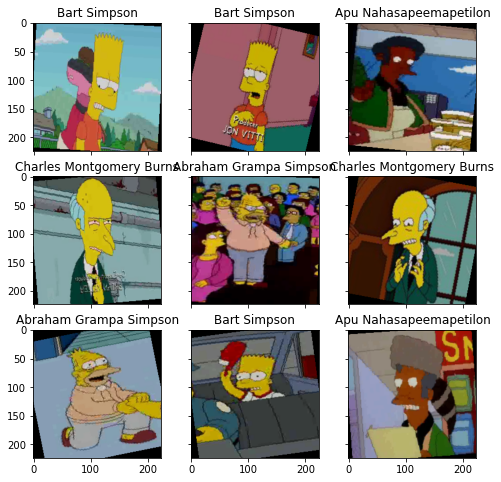

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [36]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )        
        self.out = nn.Linear(128 * 5 * 5, n_classes)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [37]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [38]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [39]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [40]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [41]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [42]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=128)

epoch:   0%|                                                                                    | 0/20 [00:00<?, ?it/s]

loss 2.6953455940819424


epoch:   5%|███▊                                                                        | 1/20 [01:02<19:43, 62.27s/it]


Epoch 001 train_loss: 2.6953     val_loss 2.1523 train_acc 0.2701 val_acc 0.4125
loss 1.7607122218794042


epoch:  10%|███████▌                                                                    | 2/20 [02:02<18:31, 61.74s/it]


Epoch 002 train_loss: 1.7607     val_loss 1.4894 train_acc 0.5247 val_acc 0.5970
loss 1.242576428865682


epoch:  15%|███████████▍                                                                | 3/20 [03:03<17:23, 61.37s/it]


Epoch 003 train_loss: 1.2426     val_loss 1.1147 train_acc 0.6543 val_acc 0.7041
loss 0.9687452056478372


epoch:  20%|███████████████▏                                                            | 4/20 [04:03<16:17, 61.08s/it]


Epoch 004 train_loss: 0.9687     val_loss 0.9838 train_acc 0.7310 val_acc 0.7352
loss 0.7966352878022114


epoch:  25%|███████████████████                                                         | 5/20 [05:09<15:35, 62.36s/it]


Epoch 005 train_loss: 0.7966     val_loss 0.8673 train_acc 0.7809 val_acc 0.7690
loss 0.6659876390088814


epoch:  30%|██████████████████████▊                                                     | 6/20 [06:12<14:38, 62.72s/it]


Epoch 006 train_loss: 0.6660     val_loss 0.8002 train_acc 0.8110 val_acc 0.7908
loss 0.574212504584289


epoch:  35%|██████████████████████████▌                                                 | 7/20 [07:16<13:41, 63.16s/it]


Epoch 007 train_loss: 0.5742     val_loss 0.7890 train_acc 0.8415 val_acc 0.7988
loss 0.5075023248287879


epoch:  40%|██████████████████████████████▍                                             | 8/20 [08:18<12:31, 62.62s/it]


Epoch 008 train_loss: 0.5075     val_loss 0.7903 train_acc 0.8555 val_acc 0.7898
loss 0.4490710149895589


epoch:  45%|██████████████████████████████████▏                                         | 9/20 [09:20<11:29, 62.65s/it]


Epoch 009 train_loss: 0.4491     val_loss 0.7371 train_acc 0.8699 val_acc 0.8121
loss 0.40335227385948536


epoch:  50%|█████████████████████████████████████▌                                     | 10/20 [10:21<10:21, 62.12s/it]


Epoch 010 train_loss: 0.4034     val_loss 0.6661 train_acc 0.8836 val_acc 0.8355
loss 0.36607744790525143


epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [11:22<09:15, 61.68s/it]


Epoch 011 train_loss: 0.3661     val_loss 0.6911 train_acc 0.8961 val_acc 0.8277
loss 0.3256668352777552


epoch:  60%|█████████████████████████████████████████████                              | 12/20 [12:22<08:10, 61.27s/it]


Epoch 012 train_loss: 0.3257     val_loss 0.6823 train_acc 0.9055 val_acc 0.8317
loss 0.2973470772598126


epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [13:23<07:07, 61.04s/it]


Epoch 013 train_loss: 0.2973     val_loss 0.6812 train_acc 0.9132 val_acc 0.8397
loss 0.2659124379836311


epoch:  70%|████████████████████████████████████████████████████▌                      | 14/20 [14:24<06:05, 60.99s/it]


Epoch 014 train_loss: 0.2659     val_loss 0.6649 train_acc 0.9249 val_acc 0.8377
loss 0.26403933750068925


epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [15:24<05:04, 60.92s/it]


Epoch 015 train_loss: 0.2640     val_loss 0.6722 train_acc 0.9222 val_acc 0.8436
loss 0.23675243421422248


epoch:  80%|████████████████████████████████████████████████████████████               | 16/20 [16:25<04:03, 60.83s/it]


Epoch 016 train_loss: 0.2368     val_loss 0.6883 train_acc 0.9290 val_acc 0.8463
loss 0.21987640822384003


epoch:  85%|███████████████████████████████████████████████████████████████▊           | 17/20 [17:26<03:02, 60.90s/it]


Epoch 017 train_loss: 0.2199     val_loss 0.6934 train_acc 0.9343 val_acc 0.8529
loss 0.20908937520309806


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [18:26<02:01, 60.77s/it]


Epoch 018 train_loss: 0.2091     val_loss 0.7111 train_acc 0.9366 val_acc 0.8545
loss 0.19472200990045466


epoch:  95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [19:27<01:00, 60.75s/it]


Epoch 019 train_loss: 0.1947     val_loss 0.7400 train_acc 0.9416 val_acc 0.8377
loss 0.19224262425277133


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [20:28<00:00, 61.43s/it]


Epoch 020 train_loss: 0.1922     val_loss 0.6771 train_acc 0.9427 val_acc 0.8618


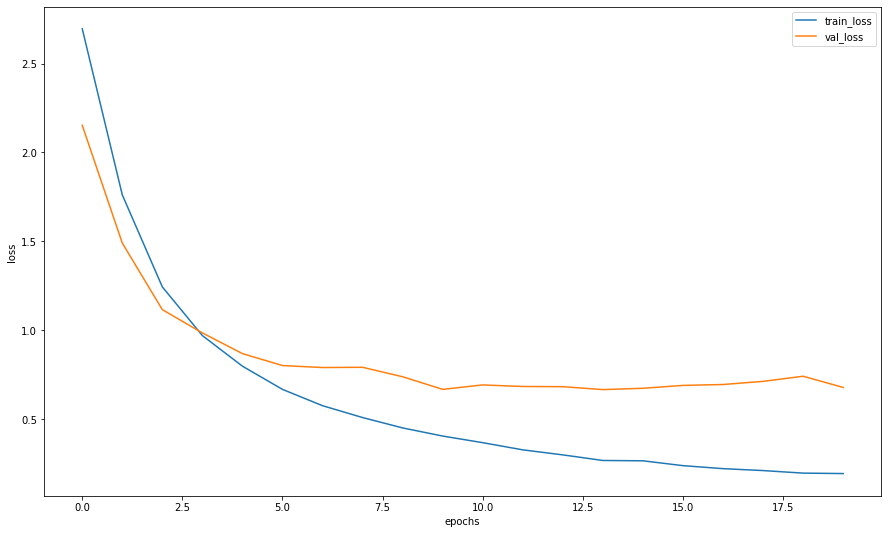

In [43]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [45]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [46]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(simple_cnn, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

f1_score(actual_labels, y_pred, average='weighted')

0.9457516339869281

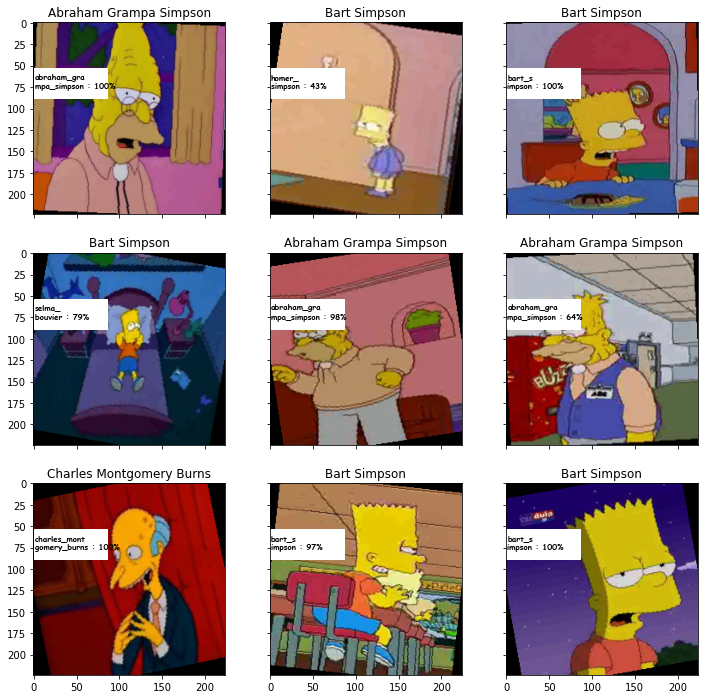

In [47]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [48]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

my_submit.to_csv('./out/my_submit_aug_epochs20.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
